In [47]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import librosa
import IPython.display as ipd
from datasets import load_dataset
from transformers import AutoConfig, Wav2Vec2Processor
import matplotlib.pyplot as plt
import seaborn as sns

# Data Recovery

In [2]:
emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

data = []

dataset_path = Path("../dataset")

for path in tqdm(dataset_path.glob("**/*.wav")):
    name = str(path).split('\\')[-1].split('.')[0]
    label_code = name.split('-')[2]  # Emotional Code Extraction
    emotion = emotion_mapping.get(label_code, "unknown")

    try:
        s = torchaudio.load(path)
        # File added to "data" in dictionary format
        data.append({
            "name": name,
            "path": str(path),
            "emotion": emotion
        })
    except Exception as e:
        pass


1440it [00:04, 293.88it/s]


In [3]:
df = pd.DataFrame(data)
df.head()

,name,path,emotion
0,03-01-01-01-01-01-01,..\dataset\Actor_01\03-01-01-01-01-01-01.wav,neutral
1,03-01-01-01-01-02-01,..\dataset\Actor_01\03-01-01-01-01-02-01.wav,neutral
2,03-01-01-01-02-01-01,..\dataset\Actor_01\03-01-01-01-02-01-01.wav,neutral
3,03-01-01-01-02-02-01,..\dataset\Actor_01\03-01-01-01-02-02-01.wav,neutral
4,03-01-02-01-01-01-01,..\dataset\Actor_01\03-01-02-01-01-01-01.wav,calm


## Data cleaning and mixing

In [4]:
print(f"Number of audio files before cleaning: {len(df)}")

df["status"] = df["path"].apply(lambda path: True if os.path.exists(path) else None)
df = df.dropna(subset=["path"])
df = df.drop("status", axis=1)

print(f"Number of audio files after cleaning: {len(df)}")

# Data mixing
df = df.sample(frac=1)
df = df.reset_index(drop=True)

df.head()

Number of audio files before cleaning: 1440
Number of audio files after cleaning: 1440


,name,path,emotion
0,03-01-08-02-01-02-15,..\dataset\Actor_15\03-01-08-02-01-02-15.wav,surprised
1,03-01-03-02-02-01-17,..\dataset\Actor_17\03-01-03-02-02-01-17.wav,happy
2,03-01-02-01-02-01-20,..\dataset\Actor_20\03-01-02-01-02-01-20.wav,calm
3,03-01-03-01-02-01-03,..\dataset\Actor_03\03-01-03-01-02-01-03.wav,happy
4,03-01-08-01-01-01-01,..\dataset\Actor_01\03-01-08-01-01-01-01.wav,surprised


## Visualizing data distribution

C:\Users\aubin\AppData\Local\Temp\ipykernel_19232\806197252.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")


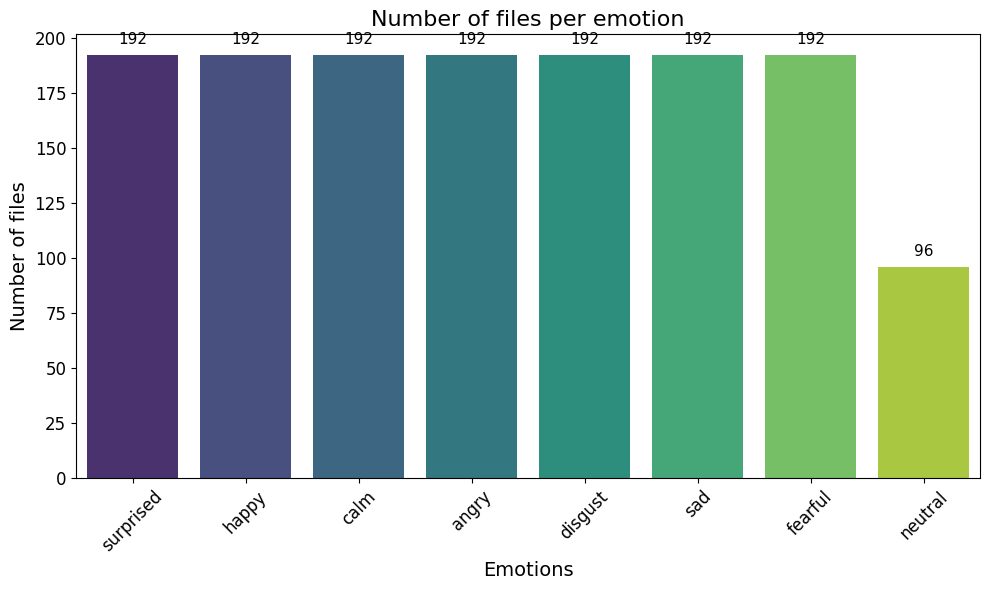

In [6]:
emotion_counts = df["emotion"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")

plt.title("Number of files per emotion", fontsize=16)
plt.xlabel("Emotions", fontsize=14)
plt.ylabel("Number of files", fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for index, value in enumerate(emotion_counts.values):
    plt.text(index, value + 5, str(value), ha='center', fontsize=11)

plt.tight_layout()
plt.show()


## Split and save training and test sets

In [7]:
save_path = "../dataset_csv"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save
train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)
print(test_df.shape)

(1152, 3)
(288, 3)


## Load data

In [8]:
data_files = {
    "train": "../dataset_csv/train.csv", 
    "validation": "../dataset_csv/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Generating train split: 1152 examples [00:00, 19301.33 examples/s]
Generating validation split: 288 examples [00:00, 55633.01 examples/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1152
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 288
})


In [9]:
input_column = "path"
output_column = "emotion"

### Control step to detect anomalies in the training assembly

In [10]:
label_list = train_dataset.unique(output_column)
label_list.sort()
num_labels = len(label_list)

print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 8 classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


# Selection of pre-trained model

In [11]:
model_name_or_path = "lighteternal/wav2vec2-large-xlsr-53-greek"
pooling_mode = "mean"

## Prepare the model for fine-tuning

In [12]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

c:\Users\aubin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [13]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
# Sampling rate expected by the model
print(f"The target sampling rate: {target_sampling_rate}")

c:\Users\aubin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


The target sampling rate: 16000


# Preprocess Data

In [66]:
# Load an audio file and transform it into an array of numerical values.
def speech_file_to_array_fn(path):
    # speech_array -> tensor with audio data
    # sampling_rate -> audio file sample rate
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    if speech.ndim == 0:
        speech = np.array([speech])
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    speech_list = [np.asarray(speech).flatten() for speech in speech_list]
    
    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [67]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1,
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=1,
)

Map: 100%|██████████| 288/288 [00:02<00:00, 121.70 examples/s]
